In [0]:
# Check GPU for Google Colab
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()
 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=79c71351c4ee97a5e72576b1115e4610a622730a85fbd8dc4ef78a4dcfdb4f86
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 10.1 GB  | Proc size: 4.3 GB
GPU RAM Free: 98MB | Used: 7513MB | Util  99% | Total 7611MB


In [0]:
!nvidia-smi

Sat Dec 28 21:16:17 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## This version uses shared weights layers.
## It uses created triplet loss

In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras import optimizers
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense, Flatten, Reshape, Dropout, Add, merge, Subtract
from keras.layers import Convolution1D, MaxPooling1D, BatchNormalization
from keras.layers import concatenate, Lambda, Activation
from keras import backend as K
from keras.utils import np_utils
import h5py
import time
import keras.layers
from keras.engine.topology import Layer
from sklearn.decomposition import PCA
from sklearn import preprocessing
import math

from scipy.spatial import distance
from sklearn.metrics import accuracy_score



import matplotlib.pyplot as plt
plt.interactive(False)
from mpl_toolkits.mplot3d import Axes3D

Using TensorFlow backend.


In [0]:
category = "living"

# number of points in each sample
num_points_whole = 2048
num_points = 64

radius = 0.8
num_parts = 1

## **This version uses different poitnet**
It works, but does not learn.
Using different triplet loss.
https://github.com/TianzhongSong/PointNet-Keras/blob/master/model_cls.py

In [0]:
def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    label = f['label'][:]
    id = f['id'][:]
    return (data, label, id)


def rotate_point_cloud(batch_data):
    """ Randomly rotate the point clouds to augument the dataset
        rotation is per shape based along up direction
        Input:
          BxNx3 array, original batch of point clouds
        Return:
          BxNx3 array, rotated batch of point clouds
    """
    rotated_data = np.zeros(batch_data.shape, dtype=np.float32)
    for k in range(batch_data.shape[0]):
        rotation_angle = np.random.uniform() * 2 * np.pi
        cosval = np.cos(rotation_angle)
        sinval = np.sin(rotation_angle)
        rotation_matrix = np.array([[cosval, 0, sinval],
                                    [0, 1, 0],
                                    [-sinval, 0, cosval]])
        shape_pc = batch_data[k, ...]
        rotated_data[k, ...] = np.dot(shape_pc.reshape((-1, 3)), rotation_matrix)
    return rotated_data


def jitter_point_cloud(batch_data, sigma=0.01, clip=0.05):
    """ Randomly jitter points. jittering is per point.
        Input:
          BxNx3 array, original batch of point clouds
        Return:
          BxNx3 array, jittered batch of point clouds
    """
    B, N, C = batch_data.shape
    assert(clip > 0)
    jittered_data = np.clip(sigma * np.random.randn(B, N, C), -1 * clip, clip)
    jittered_data += batch_data
    return jittered_data
  




class MatMul(Layer):

    def __init__(self, **kwargs):
        super(MatMul, self).__init__(**kwargs)

    def build(self, input_shape):
        # Used purely for shape validation.
        if not isinstance(input_shape, list):
            raise ValueError('`MatMul` layer should be called '
                             'on a list of inputs')
        if len(input_shape) != 2:
            raise ValueError('The input of `MatMul` layer should be a list containing 2 elements')

        if len(input_shape[0]) != 3 or len(input_shape[1]) != 3:
            raise ValueError('The dimensions of each element of inputs should be 3')

        if input_shape[0][-1] != input_shape[1][1]:
            raise ValueError('The last dimension of inputs[0] should match the dimension 1 of inputs[1]')

    def call(self, inputs):
        if not isinstance(inputs, list):
            raise ValueError('A `MatMul` layer should be called '
                             'on a list of inputs.')
        return tf.matmul(inputs[0], inputs[1])

    def compute_output_shape(self, input_shape):
        output_shape = [input_shape[0][0], input_shape[0][1], input_shape[1][-1]]
        return tuple(output_shape)


def create_base_model():
    input_points = Input(shape=(num_points, 3))
    # issues
    # input transformation net
    x = Convolution1D(64, 1, activation='relu')(input_points)
    x = BatchNormalization()(x)
    x = Convolution1D(128, 1, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Convolution1D(1024, 1, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=num_points)(x)

    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)

    x = Dense(9, weights=[np.zeros([256, 9]), np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32)])(x)
    input_T = Reshape((3, 3))(x)

    # forward net
    g = MatMul()([input_points, input_T])
    g = Convolution1D(64, 1, activation='relu')(g)
    g = BatchNormalization()(g)
    g = Convolution1D(64, 1, activation='relu')(g)
    g = BatchNormalization()(g)

    # feature transform net
    f = Convolution1D(64, 1, activation='relu')(g)
    f = BatchNormalization()(f)
    f = Convolution1D(128, 1, activation='relu')(f)
    f = BatchNormalization()(f)
    f = Convolution1D(1024, 1, activation='relu')(f)
    f = BatchNormalization()(f)
    f = MaxPooling1D(pool_size=num_points)(f)
    f = Dense(512, activation='relu')(f)
    f = BatchNormalization()(f)
    f = Dense(256, activation='relu')(f)
    f = BatchNormalization()(f)
    f = Dense(64 * 64, weights=[np.zeros([256, 64 * 64]), np.eye(64).flatten().astype(np.float32)])(f)
    feature_T = Reshape((64, 64))(f)

    # forward net
    g = MatMul()([g, feature_T])
    g = Convolution1D(64, 1, activation='relu')(g)
    g = BatchNormalization()(g)
    g = Convolution1D(128, 1, activation='relu')(g)
    g = BatchNormalization()(g)
    g = Convolution1D(1024, 1, activation='relu')(g)
    g = BatchNormalization()(g)

    # global feature
    global_feature = MaxPooling1D(pool_size=num_points)(g)
    out = Flatten(name='out')(global_feature)
    
    model = Model(inputs=input_points, outputs=out)
#     print(model.summary())

    return model


In [0]:
def triplet_loss(y_true, y_pred, alpha = 0.2, beta=0.1):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """
    total_lenght = 1024*3
    
    anchor = y_pred[:,0:int(total_lenght*1/3)]
    positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]
     
    # Normalize vectors as specified in the paper
    anchor = K.switch(K.greater_equal(K.sum(K.square(anchor)), 1), lambda: K.l2_normalize(anchor, axis=0), lambda: anchor)
    positive = K.switch(K.greater_equal(K.sum(K.square(positive)), 1), lambda: K.l2_normalize(positive, axis=0), lambda: positive)
    negative = K.switch(K.greater_equal(K.sum(K.square(negative)), 1), lambda: K.l2_normalize(negative, axis=0), lambda: negative)

    # distance between the anchor and the positive
    pos_dist = K.sqrt(K.sum(K.square(anchor-positive),axis=1))

    # distance between the anchor and the negative
    neg_dist = K.sqrt(K.sum(K.square(anchor-negative),axis=1))
 
    # compute loss
    basic_loss_a = pos_dist-neg_dist+alpha
    loss_a = K.maximum(basic_loss_a,0.0)
    
    basic_loss_b = pos_dist - beta
    loss_b = K.maximum(basic_loss_b,0.0)
    
    loss = loss_a + loss_b

    return loss

In [0]:
def compile_model(): 
  print("Compiling model...")
  input_anchor = Input(shape=(num_points, 3))
  input_positive = Input(shape=(num_points, 3))
  input_negative = Input(shape=(num_points, 3))

  model_shared = create_base_model()

  encoded_anchor = model_shared(input_anchor)
  encoded_positive = model_shared(input_positive)
  encoded_negative = model_shared(input_negative)

  optim = optimizers.Adam(lr=0.00001)
#   optim = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=0.0001, decay=0.0)
  # optim = optimizers.RMSprop(lr=0.00001)

  merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=1, name='merged_layer')

  model = Model(inputs=[input_anchor, input_positive, input_negative], outputs=merged_vector)
  model.compile(loss=triplet_loss, optimizer=optim)

  ## Visualize network
#   from keras.utils.vis_utils import plot_model as plot
#   plot(model, to_file = 'drive/My Drive/Triplet_Network_o.png')


#   model.summary()

  return model
  

# Display point cloud

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def show_pc(points):
  # select one test data to visualize
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  v_points = points
  v_points = np.squeeze(v_points)

  for i in range(v_points.shape[0]):
      xs = v_points[i,0]
      ys = v_points[i,1]
      zs = v_points[i,2]
      ax.scatter(xs, ys, zs, color="blue", s=5)

  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.set_zlabel('Z Label')
  plt.show()

## Train on Style Data 1

In [0]:
def evaluate_triplet(mode="train"):
  # Evaluate on test data
  if mode == "train":
    X_test = [Anchor_train, Positive_train, Negative_train]
    Y_dummy = np.zeros((Anchor_train.shape[0],1))
  elif mode == "test":
    X_test = [Anchor_test, Positive_test, Negative_test]
    Y_dummy = np.zeros((Anchor_test.shape[0],1))
  
  pred = model.predict(x=X_test, verbose=1)
  
  # Split into anchor, a, and b sets
  total_lenght = pred.shape[1]
  print("embedding_length: ", total_lenght/3)
  pred_anchor = pred[:,0:int(total_lenght*1/3)]
  pred_a = pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
  pred_b = pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]
  
  # Normalize vectors as specified in the paper
  for i in range(len(pred_anchor)):
    if np.sum(pred_anchor[i]**2) >= 1:
      pred_anchor[i] = preprocessing.normalize([pred_anchor[i]], norm='l2')[0]
    if np.sum(pred_a[i]**2) >= 1:
      pred_a[i] = preprocessing.normalize([pred_a[i]], norm='l2')[0]
    if np.sum(pred_b[i]**2) >= 1:
      pred_b[i] = preprocessing.normalize([pred_b[i]], norm='l2')[0]
  
#   print(pred_anchor)

  result = []
  for i in range(pred.shape[0]):
    dist1 = distance.euclidean(pred_anchor[i], pred_a[i])
    dist2 = distance.euclidean(pred_anchor[i], pred_b[i])
#     print(pred_anchor[0])
#     print(pred_a[0])
#     print(pred_b[0])
#     print("Positive dist: ", dist1)
#     print("Negative dist: ", dist2)
    if dist1 < dist2:
      result.append(0)
    else:
      result.append(1)   

  print("Evaluation accuracy: ", accuracy_score(Y_dummy, result))

  return accuracy_score(Y_dummy, result)


In [0]:
## Create two plots; accuracy and loss
def save_plot(eval_name, fold_id):
  fig = plt.figure()

  # top
  ax1 = fig.add_subplot(2, 1, 1)
  ax1.plot(df_history['train_loss'], color='blue')
  ax1.plot(df_history['val_loss'], color='darkorange')
  ax1.set_xlabel("epoch")
  ax1.set_ylabel("loss")
  plt.legend(['train_loss', 'val_loss'], loc='upper right', fontsize='x-small')
  plt.title("Fold-"+str(fold_id))

  # bottom
  ax2 = fig.add_subplot(2, 1, 2)
  ax2.plot(df_history['val_acc'], color='orange')
  ax2.set_xlabel("epoch")
  ax2.set_ylabel("accuracy")
  plt.legend(['val_accuracy'], loc='upper left', fontsize='x-small')
  
  ax1.grid()
  ax2.grid()

#   fig.show()
  fig.savefig("drive/My Drive/Saved_Images/CV_eval_pc/" + eval_name + "_parts/Fold-"+str(fold_id))
  plt.close()

In [49]:
# Load point cloud data
train_path = "drive/My Drive/pc_" + category + "/" + category + "_" + str(num_points_whole)

filenames = [d for d in os.listdir(train_path)]
print(train_path)
print(filenames)
train_points = None
train_labels = None
train_ids = None
for d in filenames:
    cur_points, cur_labels, cur_ids = load_h5(os.path.join(train_path, d))
    cur_points = cur_points.reshape(1, -1, 3)
    cur_labels = cur_labels.reshape(1, -1)
    cur_ids = cur_ids.reshape(1, -1)
    if train_labels is None or train_points is None:
        train_labels = cur_labels
        train_points = cur_points
        train_ids = cur_ids
    else:
        train_labels = np.hstack((train_labels, cur_labels))
        train_points = np.hstack((train_points, cur_points))
        train_ids = np.hstack((train_ids, cur_ids))
train_points_r = train_points.reshape(-1, num_points_whole, 3)
train_labels_r = train_labels.reshape(-1, 1)
train_ids_r = train_ids.reshape(-1, 1)



def data_generator(fold_id, parts_index):  
  ## Generate training/test data
  df_train = pd.read_pickle("drive/My Drive/10CV_df/" + category + "/df_train_" + str(fold_id) + ".csv")
  df_test = pd.read_pickle("drive/My Drive/10CV_df/" + category + "/df_test_" + str(fold_id) + ".csv")
  print("Train size: ", len(df_train))
  print("Test size: ", len(df_test))

  df_train = df_train.reset_index(drop=True)
  df_test = df_test.reset_index(drop=True)

  out_list = []
  ################ Generate Training Data ################
  name_list = ["query", "pos", "neg"]
  data_length = len(df_train)

  for k in range(0,3):
    print("Generating training data", k+1, "/3...")
    input_data = pd.DataFrame()
    df_ids = pd.DataFrame(train_ids_r)
    for i in range(data_length):
        data_id = df_train.loc[:,name_list[k]][i]
        id_index = df_ids[df_ids[0].astype(str)== ("b'"+data_id + ".off'")].index
     
        pc = train_points_r[id_index[0]]
        df_part_list = []
        for j in range(parts_index, num_parts + parts_index):
          p_center = pc[j]
          x_center = p_center[0]
          y_center = p_center[1]
          z_center = p_center[2]

          df_part = pd.DataFrame()
          while len(df_part) < num_points:
            for i in range(0,len(pc)):
                if math.sqrt((x_center-pc[i][0])**2 + (y_center-pc[i][1])**2 + (z_center-pc[i][2])**2) <= radius and len(df_part) < num_points:
                  df_part = df_part.append(pd.DataFrame(pc[i]).T)
                  
          input_data = input_data.append(pd.DataFrame(df_part))
        
    input_data = input_data.as_matrix()
    input_data = input_data.reshape(-1, num_points, 3)
    out_list.append(np.array(input_data))


  ############### Generate Test Data #########################
  num_parts_test = 2
  
  data_length = len(df_test)

  for k in range(0,3):
    print("Generating test data", k+1, "/3...")
    input_data = pd.DataFrame()
    df_ids = pd.DataFrame(train_ids_r)
    for i in range(data_length):
        data_id = df_test.loc[:,name_list[k]][i]
        id_index = df_ids[df_ids[0].astype(str)== ("b'"+data_id + ".off'")].index
        pc = train_points_r[id_index[0]]
        df_part_list = []
        for j in range(parts_index, num_parts_test + parts_index):
          p_center = pc[j]
          x_center = p_center[0]
          y_center = p_center[1]
          z_center = p_center[2]
 
          df_part = pd.DataFrame()
          while len(df_part) < num_points:
            for i in range(0,len(pc)):
                if math.sqrt((x_center-pc[i][0])**2 + (y_center-pc[i][1])**2 + (z_center-pc[i][2])**2) <= radius and len(df_part) < num_points:
                  df_part = df_part.append(pd.DataFrame(pc[i]).T)
                  
          input_data = input_data.append(pd.DataFrame(df_part))
    input_data = input_data.as_matrix()
    input_data = input_data.reshape(-1, num_points, 3)
    out_list.append(np.array(input_data))
    
  print("Train size total: ", out_list[0].shape)
  print("Test size total: ", out_list[3].shape)
  
  return out_list


def data_re_generator(fold_id, parts_index):  
  ## Generate training/test data
  df_train = pd.read_pickle("drive/My Drive/10CV_df/" + category + "/df_train_" + str(fold_id) + ".csv")
  df_test = pd.read_pickle("drive/My Drive/10CV_df/" + category + "/df_test_" + str(fold_id) + ".csv")
  print("Train size: ", len(df_train))
  print("Test size: ", len(df_test))

  df_train = df_train.reset_index(drop=True)
  df_test = df_test.reset_index(drop=True)

  out_list = []
  ################ Generate Training Data ################
  name_list = ["query", "pos", "neg"]
  data_length = len(df_train)

  for k in range(0,3):
    print("Generating training data", k+1, "/3...")
    input_data = pd.DataFrame()
    df_ids = pd.DataFrame(train_ids_r)
    for i in range(data_length):
        data_id = df_train.loc[:,name_list[k]][i]
        id_index = df_ids[df_ids[0].astype(str)== ("b'"+data_id + ".off'")].index
     
        pc = train_points_r[id_index[0]]
        df_part_list = []
        for j in range(parts_index, num_parts + parts_index):
          p_center = pc[j]
          x_center = p_center[0]
          y_center = p_center[1]
          z_center = p_center[2]

          df_part = pd.DataFrame()
          while len(df_part) < num_points:
            for i in range(0,len(pc)):
                if math.sqrt((x_center-pc[i][0])**2 + (y_center-pc[i][1])**2 + (z_center-pc[i][2])**2) <= radius and len(df_part) < num_points:
                  df_part = df_part.append(pd.DataFrame(pc[i]).T)
                  
          input_data = input_data.append(pd.DataFrame(df_part))
        
    input_data = input_data.as_matrix()
    input_data = input_data.reshape(-1, num_points, 3)
    out_list.append(np.array(input_data))
    
  return out_list


drive/My Drive/pc_living/living_2048
['living_2048.h5']


In [0]:
# %%capture
# import warnings
# warnings.filterwarnings("ignore")


print("num_points: ", num_points)
print("num_points_whole: ", num_points_whole)
print("radius: ", radius)
print("num_parts: ", num_parts)

# Time
start = time.time()
##### 10-fold cross-validation ###########
parts_index = 0
for k in range(2,6):
  
  print("==================== Fold:", k, "/10 ========================")
  ####### Use for style data 1 #######
  # Training and testing data
  generated_data = data_generator(k, parts_index)
  Anchor_train_orig = generated_data[0]
  Positive_train_orig = generated_data[1]
  Negative_train_orig = generated_data[2]

  Anchor_test = generated_data[3]
  Positive_test = generated_data[4]
  Negative_test = generated_data[5]

  Y_dummy1 = np.zeros((Anchor_train_orig.shape[0],1))
  Y_dummy2 = np.zeros((Anchor_test.shape[0],1))

  # Compile model
  model = compile_model()
  
  num_epoch = 200
  # Fit model on training data
  df_history = pd.DataFrame(columns=['train_loss','val_loss','train_acc','val_acc'])
  for i in range(1, num_epoch+1):
    print("\n Total epoch:", i, "/", num_epoch)

    if i==1 or i%20==1:
      Anchor_train = Anchor_train_orig
      Positive_train = Positive_train_orig
      Negative_train = Negative_train_orig

    # Evaluation
    val_acc = evaluate_triplet("test")
    train_acc = evaluate_triplet("train")

    history = model.fit(x=[Anchor_train, Positive_train, Negative_train], y=Y_dummy1,\
                           validation_data=([Anchor_test,Positive_test,Negative_test],Y_dummy2),\
                           batch_size=16, shuffle=True, epochs=1,verbose=1)


    df_history = df_history.append(pd.DataFrame([history.history['loss'], history.history['val_loss'], [train_acc], [val_acc]],
                                               index=['train_loss','val_loss','train_acc','val_acc']).T)
    df_history = df_history.reset_index(drop="Ture")
    
    if i%20==0:
      parts_index += num_parts
      # Generate new sub-parts
      print("parts_index", parts_index)
      generated_data = data_re_generator(k,parts_index)
      Anchor_train_orig = generated_data[0]
      Positive_train_orig = generated_data[1]
      Negative_train_orig = generated_data[2]
    
    # rotate and jitter the points
    train_points_rotate = rotate_point_cloud(Anchor_train_orig)
    train_points_jitter = jitter_point_cloud(train_points_rotate)
    Anchor_train = train_points_jitter
    train_points_rotate = rotate_point_cloud(Positive_train_orig)
    train_points_jitter = jitter_point_cloud(train_points_rotate)
    Positive_train = train_points_jitter
    train_points_rotate = rotate_point_cloud(Negative_train_orig)
    train_points_jitter = jitter_point_cloud(train_points_rotate)
    Negative_train = train_points_jitter

    # Elapsed time
    elapsed_time = time.time() - start
    print("Elapsed time:", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

    if i%10==0 and i>1:
      # Create and save plot
      save_plot(category, fold_id=k)
      # Save a list of accuracy
      df_history.to_csv("drive/My Drive/PointCloudAccuracy_10CV/" + category + "_parts/df_log_"+ str(k) + ".csv")
  

num_points:  64
num_points_whole:  2048
radius:  0.8
num_parts:  1
==================== Fold: 2 /10 ========================
Train size:  462
Test size:  45
Generating training data 1 /3...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating training data 2 /3...
Generating training data 3 /3...
Generating test data 1 /3...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating test data 2 /3...
Generating test data 3 /3...
Train size total:  (462, 64, 3)
Test size total:  (90, 64, 3)
Compiling model...

 Total epoch: 1 / 200
90/90 [==============================] - 33s 366ms/step
embedding_length:  1024.0
Evaluation accuracy:  0.5111111111111111
462/462 [==============================] - 0s 681us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5043290043290043
Train on 462 samples, validate on 90 samples
Epoch 1/1
462/462 [==============================] - 48s 105ms/step - loss: 4.1178 - val_loss: 4.3112
Elapsed time: 00:04:49

 Total epoch: 2 / 200
90/90 [==============================] - 0s 630us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5222222222222223
462/462 [==============================] - 0s 631us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5346320346320347
Train on 462 samples, validate on 90 samples
Epoch 1/1
462/462 [==============================] - 3s 6ms/step - loss: 3.9714 - val_loss: 3.9861
Elapsed 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating training data 2 /3...
Generating training data 3 /3...
Elapsed time: 00:07:22

 Total epoch: 21 / 200
90/90 [==============================] - 0s 770us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5555555555555556
462/462 [==============================] - 0s 638us/step
embedding_length:  1024.0
Evaluation accuracy:  0.577922077922078
Train on 462 samples, validate on 90 samples
Epoch 1/1
462/462 [==============================] - 3s 6ms/step - loss: 2.8355 - val_loss: 2.9267
Elapsed time: 00:07:25

 Total epoch: 22 / 200
90/90 [==============================] - 0s 667us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5222222222222223
462/462 [==============================] - 0s 611us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5541125541125541
Train on 462 samples, validate on 90 samples
Epoch 1/1
462/462 [==============================] - 3s 6ms/step - loss: 2.8751 - val_loss: 2.8546
Elapsed time: 00:07:29

 Total epoch: 23 / 200
90/90 [=======

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating training data 2 /3...
Generating training data 3 /3...
Elapsed time: 00:09:59

 Total epoch: 41 / 200
90/90 [==============================] - 0s 725us/step
embedding_length:  1024.0
Evaluation accuracy:  0.6111111111111112
462/462 [==============================] - 0s 642us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5887445887445888
Train on 462 samples, validate on 90 samples
Epoch 1/1
462/462 [==============================] - 3s 6ms/step - loss: 2.4908 - val_loss: 2.4625
Elapsed time: 00:10:03

 Total epoch: 42 / 200
90/90 [==============================] - 0s 638us/step
embedding_length:  1024.0
Evaluation accuracy:  0.6111111111111112
462/462 [==============================] - 0s 593us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5670995670995671
Train on 462 samples, validate on 90 samples
Epoch 1/1
462/462 [==============================] - 3s 6ms/step - loss: 2.4945 - val_loss: 2.4742
Elapsed time: 00:10:06

 Total epoch: 43 / 200
90/90 [======

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


 1 /3...
Generating training data 2 /3...
Generating training data 3 /3...
Elapsed time: 00:12:37

 Total epoch: 61 / 200
90/90 [==============================] - 0s 665us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5888888888888889
462/462 [==============================] - 0s 640us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5844155844155844
Train on 462 samples, validate on 90 samples
Epoch 1/1
462/462 [==============================] - 3s 6ms/step - loss: 2.2329 - val_loss: 2.1988
Elapsed time: 00:12:40

 Total epoch: 62 / 200
90/90 [==============================] - 0s 703us/step
embedding_length:  1024.0
Evaluation accuracy:  0.6
462/462 [==============================] - 0s 677us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5974025974025974
Train on 462 samples, validate on 90 samples
Epoch 1/1
462/462 [==============================] - 3s 6ms/step - loss: 2.2297 - val_loss: 2.1587
Elapsed time: 00:12:44

 Total epoch: 63 / 200
90/90 [============

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating training data 2 /3...
Generating training data 3 /3...
Elapsed time: 00:15:14

 Total epoch: 81 / 200
90/90 [==============================] - 0s 745us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5888888888888889
462/462 [==============================] - 0s 649us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5952380952380952
Train on 462 samples, validate on 90 samples
Epoch 1/1
462/462 [==============================] - 3s 6ms/step - loss: 2.0154 - val_loss: 1.9589
Elapsed time: 00:15:18

 Total epoch: 82 / 200
90/90 [==============================] - 0s 639us/step
embedding_length:  1024.0
Evaluation accuracy:  0.6333333333333333
462/462 [==============================] - 0s 629us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5865800865800865
Train on 462 samples, validate on 90 samples
Epoch 1/1
462/462 [==============================] - 3s 6ms/step - loss: 2.0661 - val_loss: 1.9538
Elapsed time: 00:15:21

 Total epoch: 83 / 200
90/90 [======

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating training data 2 /3...
Generating training data 3 /3...
Elapsed time: 00:17:51

 Total epoch: 101 / 200
90/90 [==============================] - 0s 666us/step
embedding_length:  1024.0
Evaluation accuracy:  0.6333333333333333
462/462 [==============================] - 0s 660us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5822510822510822
Train on 462 samples, validate on 90 samples
Epoch 1/1
462/462 [==============================] - 3s 6ms/step - loss: 1.8752 - val_loss: 1.8444
Elapsed time: 00:17:55

 Total epoch: 102 / 200
90/90 [==============================] - 0s 675us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5444444444444444
462/462 [==============================] - 0s 648us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5367965367965368
Train on 462 samples, validate on 90 samples
Epoch 1/1
462/462 [==============================] - 3s 6ms/step - loss: 1.8740 - val_loss: 1.8465
Elapsed time: 00:17:58

 Total epoch: 103 / 200
90/90 [===

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating training data 2 /3...
Generating training data 3 /3...
Elapsed time: 00:20:28

 Total epoch: 121 / 200
90/90 [==============================] - 0s 675us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5888888888888889
462/462 [==============================] - 0s 659us/step
embedding_length:  1024.0
Evaluation accuracy:  0.6341991341991342
Train on 462 samples, validate on 90 samples
Epoch 1/1
462/462 [==============================] - 3s 6ms/step - loss: 1.8236 - val_loss: 1.7072
Elapsed time: 00:20:32

 Total epoch: 122 / 200
90/90 [==============================] - 0s 675us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5777777777777777
462/462 [==============================] - 0s 653us/step
embedding_length:  1024.0
Evaluation accuracy:  0.6103896103896104
Train on 462 samples, validate on 90 samples
Epoch 1/1
462/462 [==============================] - 3s 6ms/step - loss: 1.8286 - val_loss: 1.6882
Elapsed time: 00:20:35

 Total epoch: 123 / 200
90/90 [===

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating training data 2 /3...
Generating training data 3 /3...
Elapsed time: 00:23:05

 Total epoch: 141 / 200
90/90 [==============================] - 0s 700us/step
embedding_length:  1024.0
Evaluation accuracy:  0.6222222222222222
462/462 [==============================] - 0s 651us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5887445887445888
Train on 462 samples, validate on 90 samples
Epoch 1/1
462/462 [==============================] - 3s 6ms/step - loss: 1.7443 - val_loss: 1.6071
Elapsed time: 00:23:09

 Total epoch: 142 / 200
90/90 [==============================] - 0s 659us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5555555555555556
462/462 [==============================] - 0s 681us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5844155844155844
Train on 462 samples, validate on 90 samples
Epoch 1/1
462/462 [==============================] - 3s 6ms/step - loss: 1.7128 - val_loss: 1.6165
Elapsed time: 00:23:12

 Total epoch: 143 / 200
90/90 [===

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating training data 2 /3...
Generating training data 3 /3...
Elapsed time: 00:25:42

 Total epoch: 161 / 200
90/90 [==============================] - 0s 735us/step
embedding_length:  1024.0
Evaluation accuracy:  0.6
462/462 [==============================] - 0s 623us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5844155844155844
Train on 462 samples, validate on 90 samples
Epoch 1/1
462/462 [==============================] - 3s 6ms/step - loss: 1.5243 - val_loss: 1.5103
Elapsed time: 00:25:46

 Total epoch: 162 / 200
90/90 [==============================] - 0s 631us/step
embedding_length:  1024.0
Evaluation accuracy:  0.6222222222222222
462/462 [==============================] - 0s 609us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5627705627705628
Train on 462 samples, validate on 90 samples
Epoch 1/1
462/462 [==============================] - 3s 6ms/step - loss: 1.5246 - val_loss: 1.4656
Elapsed time: 00:25:49

 Total epoch: 163 / 200
90/90 [==================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating training data 2 /3...
Generating training data 3 /3...
Elapsed time: 00:28:20

 Total epoch: 181 / 200
90/90 [==============================] - 0s 782us/step
embedding_length:  1024.0
Evaluation accuracy:  0.6
462/462 [==============================] - 0s 660us/step
embedding_length:  1024.0
Evaluation accuracy:  0.6017316017316018
Train on 462 samples, validate on 90 samples
Epoch 1/1
462/462 [==============================] - 3s 6ms/step - loss: 1.4880 - val_loss: 1.4048
Elapsed time: 00:28:23

 Total epoch: 182 / 200
90/90 [==============================] - 0s 700us/step
embedding_length:  1024.0
Evaluation accuracy:  0.6
462/462 [==============================] - 0s 622us/step
embedding_length:  1024.0
Evaluation accuracy:  0.6103896103896104
Train on 462 samples, validate on 90 samples
Epoch 1/1
462/462 [==============================] - 3s 6ms/step - loss: 1.4499 - val_loss: 1.3921
Elapsed time: 00:28:27

 Total epoch: 183 / 200
90/90 [==============================] -

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating training data 2 /3...
Generating training data 3 /3...
Elapsed time: 00:30:56
==================== Fold: 3 /10 ========================
Train size:  567
Test size:  45
Generating training data 1 /3...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating training data 2 /3...
Generating training data 3 /3...
Generating test data 1 /3...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating test data 2 /3...
Generating test data 3 /3...
Train size total:  (567, 64, 3)
Test size total:  (90, 64, 3)
Compiling model...

 Total epoch: 1 / 200
90/90 [==============================] - 35s 390ms/step
embedding_length:  1024.0
Evaluation accuracy:  0.5111111111111111
567/567 [==============================] - 0s 700us/step
embedding_length:  1024.0
Evaluation accuracy:  0.43209876543209874
Train on 567 samples, validate on 90 samples
Epoch 1/1
567/567 [==============================] - 52s 91ms/step - loss: 4.3132 - val_loss: 4.1878
Elapsed time: 00:36:19

 Total epoch: 2 / 200
90/90 [==============================] - 0s 707us/step
embedding_length:  1024.0
Evaluation accuracy:  0.4888888888888889
567/567 [==============================] - 0s 668us/step
embedding_length:  1024.0
Evaluation accuracy:  0.4673721340388007
Train on 567 samples, validate on 90 samples
Epoch 1/1
567/567 [==============================] - 4s 6ms/step - loss: 4.1397 - val_loss: 3.8820
Elapsed 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating training data 2 /3...
Generating training data 3 /3...
Elapsed time: 00:39:26

 Total epoch: 21 / 200
90/90 [==============================] - 0s 765us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5888888888888889
567/567 [==============================] - 0s 655us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5097001763668431
Train on 567 samples, validate on 90 samples
Epoch 1/1
567/567 [==============================] - 3s 6ms/step - loss: 2.9041 - val_loss: 2.8241
Elapsed time: 00:39:30

 Total epoch: 22 / 200
90/90 [==============================] - 0s 633us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5666666666666667
567/567 [==============================] - 0s 613us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5185185185185185
Train on 567 samples, validate on 90 samples
Epoch 1/1
567/567 [==============================] - 4s 6ms/step - loss: 2.9153 - val_loss: 2.8539
Elapsed time: 00:39:35

 Total epoch: 23 / 200
90/90 [======

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating training data 2 /3...
Generating training data 3 /3...
Elapsed time: 00:42:38

 Total epoch: 41 / 200
90/90 [==============================] - 0s 750us/step
embedding_length:  1024.0
Evaluation accuracy:  0.6111111111111112
567/567 [==============================] - 0s 645us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5414462081128748
Train on 567 samples, validate on 90 samples
Epoch 1/1
567/567 [==============================] - 4s 6ms/step - loss: 2.5327 - val_loss: 2.4113
Elapsed time: 00:42:42

 Total epoch: 42 / 200
90/90 [==============================] - 0s 678us/step
embedding_length:  1024.0
Evaluation accuracy:  0.6111111111111112
567/567 [==============================] - 0s 634us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5379188712522046
Train on 567 samples, validate on 90 samples
Epoch 1/1
567/567 [==============================] - 3s 6ms/step - loss: 2.5132 - val_loss: 2.3868
Elapsed time: 00:42:47

 Total epoch: 43 / 200
90/90 [======

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating training data 2 /3...
Generating training data 3 /3...
Elapsed time: 00:45:50

 Total epoch: 61 / 200
90/90 [==============================] - 0s 762us/step
embedding_length:  1024.0
Evaluation accuracy:  0.6222222222222222
567/567 [==============================] - 0s 679us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5661375661375662
Train on 567 samples, validate on 90 samples
Epoch 1/1
567/567 [==============================] - 3s 6ms/step - loss: 2.2563 - val_loss: 2.1367
Elapsed time: 00:45:54

 Total epoch: 62 / 200
90/90 [==============================] - 0s 628us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5555555555555556
567/567 [==============================] - 0s 635us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5555555555555556
Train on 567 samples, validate on 90 samples
Epoch 1/1
567/567 [==============================] - 3s 6ms/step - loss: 2.2811 - val_loss: 2.0987
Elapsed time: 00:45:58

 Total epoch: 63 / 200
90/90 [======

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating training data 2 /3...
Generating training data 3 /3...
Elapsed time: 00:49:02

 Total epoch: 81 / 200
90/90 [==============================] - 0s 731us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5333333333333333
567/567 [==============================] - 0s 637us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5520282186948854
Train on 567 samples, validate on 90 samples
Epoch 1/1
567/567 [==============================] - 4s 6ms/step - loss: 2.0540 - val_loss: 2.0085
Elapsed time: 00:49:06

 Total epoch: 82 / 200
90/90 [==============================] - 0s 674us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5333333333333333
567/567 [==============================] - 0s 645us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5185185185185185
Train on 567 samples, validate on 90 samples
Epoch 1/1
567/567 [==============================] - 3s 6ms/step - loss: 2.0248 - val_loss: 1.8801
Elapsed time: 00:49:10

 Total epoch: 83 / 200
90/90 [======

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating training data 2 /3...
Generating training data 3 /3...
Elapsed time: 00:52:15

 Total epoch: 101 / 200
90/90 [==============================] - 0s 794us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5777777777777777
567/567 [==============================] - 0s 668us/step
embedding_length:  1024.0
Evaluation accuracy:  0.4973544973544973
Train on 567 samples, validate on 90 samples
Epoch 1/1
567/567 [==============================] - 3s 6ms/step - loss: 1.9991 - val_loss: 1.7682
Elapsed time: 00:52:19

 Total epoch: 102 / 200
90/90 [==============================] - 0s 628us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5777777777777777
567/567 [==============================] - 0s 633us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5220458553791887
Train on 567 samples, validate on 90 samples
Epoch 1/1
567/567 [==============================] - 3s 6ms/step - loss: 1.9881 - val_loss: 1.8599
Elapsed time: 00:52:23

 Total epoch: 103 / 200
90/90 [===

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating training data 2 /3...
Generating training data 3 /3...
Elapsed time: 00:55:27

 Total epoch: 121 / 200
90/90 [==============================] - 0s 643us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5444444444444444
567/567 [==============================] - 0s 669us/step
embedding_length:  1024.0
Evaluation accuracy:  0.4973544973544973
Train on 567 samples, validate on 90 samples
Epoch 1/1
567/567 [==============================] - 3s 6ms/step - loss: 1.7206 - val_loss: 1.7617
Elapsed time: 00:55:31

 Total epoch: 122 / 200
90/90 [==============================] - 0s 666us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5333333333333333
567/567 [==============================] - 0s 625us/step
embedding_length:  1024.0
Evaluation accuracy:  0.49559082892416223
Train on 567 samples, validate on 90 samples
Epoch 1/1
567/567 [==============================] - 4s 6ms/step - loss: 1.7308 - val_loss: 1.7263
Elapsed time: 00:55:35

 Total epoch: 123 / 200
90/90 [==

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating training data 2 /3...
Generating training data 3 /3...
Elapsed time: 00:58:39

 Total epoch: 141 / 200
90/90 [==============================] - 0s 734us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5777777777777777
567/567 [==============================] - 0s 639us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5696649029982364
Train on 567 samples, validate on 90 samples
Epoch 1/1
567/567 [==============================] - 3s 6ms/step - loss: 1.6353 - val_loss: 1.5686
Elapsed time: 00:58:44

 Total epoch: 142 / 200
90/90 [==============================] - 0s 666us/step
embedding_length:  1024.0
Evaluation accuracy:  0.4666666666666667
567/567 [==============================] - 0s 662us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5202821869488536
Train on 567 samples, validate on 90 samples
Epoch 1/1
567/567 [==============================] - 3s 6ms/step - loss: 1.6271 - val_loss: 1.5450
Elapsed time: 00:58:48

 Total epoch: 143 / 200
90/90 [===

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating training data 2 /3...
Generating training data 3 /3...
Elapsed time: 01:01:52

 Total epoch: 161 / 200
90/90 [==============================] - 0s 721us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5666666666666667
567/567 [==============================] - 0s 656us/step
embedding_length:  1024.0
Evaluation accuracy:  0.562610229276896
Train on 567 samples, validate on 90 samples
Epoch 1/1
567/567 [==============================] - 3s 6ms/step - loss: 1.5429 - val_loss: 1.4263
Elapsed time: 01:01:56

 Total epoch: 162 / 200
90/90 [==============================] - 0s 674us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5888888888888889
567/567 [==============================] - 0s 660us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5432098765432098
Train on 567 samples, validate on 90 samples
Epoch 1/1
567/567 [==============================] - 3s 6ms/step - loss: 1.5143 - val_loss: 1.4383
Elapsed time: 01:02:01

 Total epoch: 163 / 200
90/90 [====

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating training data 2 /3...
Generating training data 3 /3...
Elapsed time: 01:05:04

 Total epoch: 181 / 200
90/90 [==============================] - 0s 749us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5222222222222223
567/567 [==============================] - 0s 656us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5432098765432098
Train on 567 samples, validate on 90 samples
Epoch 1/1
567/567 [==============================] - 3s 6ms/step - loss: 1.5043 - val_loss: 1.3073
Elapsed time: 01:05:09

 Total epoch: 182 / 200
90/90 [==============================] - 0s 725us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5222222222222223
567/567 [==============================] - 0s 650us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5520282186948854
Train on 567 samples, validate on 90 samples
Epoch 1/1
567/567 [==============================] - 4s 6ms/step - loss: 1.4747 - val_loss: 1.3139
Elapsed time: 01:05:13

 Total epoch: 183 / 200
90/90 [===

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating training data 2 /3...
Generating training data 3 /3...
Elapsed time: 01:08:17
==================== Fold: 4 /10 ========================
Train size:  535
Test size:  45
Generating training data 1 /3...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating training data 2 /3...
Generating training data 3 /3...
Generating test data 1 /3...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating test data 2 /3...
Generating test data 3 /3...
Train size total:  (535, 64, 3)
Test size total:  (90, 64, 3)
Compiling model...

 Total epoch: 1 / 200
90/90 [==============================] - 38s 421ms/step
embedding_length:  1024.0
Evaluation accuracy:  0.4666666666666667
535/535 [==============================] - 0s 692us/step
embedding_length:  1024.0
Evaluation accuracy:  0.48598130841121495
Train on 535 samples, validate on 90 samples
Epoch 1/1
535/535 [==============================] - 54s 102ms/step - loss: 4.3777 - val_loss: 4.4566
Elapsed time: 01:13:48

 Total epoch: 2 / 200
90/90 [==============================] - 0s 785us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5666666666666667
535/535 [==============================] - 0s 675us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5607476635514018
Train on 535 samples, validate on 90 samples
Epoch 1/1
535/535 [==============================] - 3s 6ms/step - loss: 4.1448 - val_loss: 4.1689
Elapsed

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating training data 2 /3...
Generating training data 3 /3...
Elapsed time: 01:16:47

 Total epoch: 21 / 200
90/90 [==============================] - 0s 746us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5
535/535 [==============================] - 0s 672us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5420560747663551
Train on 535 samples, validate on 90 samples
Epoch 1/1
535/535 [==============================] - 3s 6ms/step - loss: 2.8889 - val_loss: 2.9393
Elapsed time: 01:16:51

 Total epoch: 22 / 200
90/90 [==============================] - 0s 689us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5
535/535 [==============================] - 0s 629us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5682242990654206
Train on 535 samples, validate on 90 samples
Epoch 1/1
535/535 [==============================] - 3s 6ms/step - loss: 2.8598 - val_loss: 2.9097
Elapsed time: 01:16:55

 Total epoch: 23 / 200
90/90 [==============================] - 0s

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating training data 2 /3...
Generating training data 3 /3...
Elapsed time: 01:19:50

 Total epoch: 41 / 200
90/90 [==============================] - 0s 786us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5555555555555556
535/535 [==============================] - 0s 660us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5327102803738317
Train on 535 samples, validate on 90 samples
Epoch 1/1
535/535 [==============================] - 3s 6ms/step - loss: 2.5149 - val_loss: 2.4579
Elapsed time: 01:19:54

 Total epoch: 42 / 200
90/90 [==============================] - 0s 699us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5222222222222223
535/535 [==============================] - 0s 636us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5345794392523364
Train on 535 samples, validate on 90 samples
Epoch 1/1
535/535 [==============================] - 3s 6ms/step - loss: 2.4770 - val_loss: 2.4498
Elapsed time: 01:19:58

 Total epoch: 43 / 200
90/90 [======

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating training data 2 /3...
Generating training data 3 /3...
Elapsed time: 01:22:53

 Total epoch: 61 / 200
90/90 [==============================] - 0s 779us/step
embedding_length:  1024.0
Evaluation accuracy:  0.6
535/535 [==============================] - 0s 653us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5551401869158878
Train on 535 samples, validate on 90 samples
Epoch 1/1
535/535 [==============================] - 3s 6ms/step - loss: 2.3021 - val_loss: 2.1495
Elapsed time: 01:22:57

 Total epoch: 62 / 200
90/90 [==============================] - 0s 645us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5555555555555556
535/535 [==============================] - 0s 651us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5682242990654206
Train on 535 samples, validate on 90 samples
Epoch 1/1
535/535 [==============================] - 3s 6ms/step - loss: 2.2265 - val_loss: 2.1116
Elapsed time: 01:23:01

 Total epoch: 63 / 200
90/90 [=====================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating training data 2 /3...
Generating training data 3 /3...
Elapsed time: 01:25:56

 Total epoch: 81 / 200
90/90 [==============================] - 0s 780us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5666666666666667
535/535 [==============================] - 0s 672us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5420560747663551
Train on 535 samples, validate on 90 samples
Epoch 1/1
535/535 [==============================] - 3s 6ms/step - loss: 2.0377 - val_loss: 1.9511
Elapsed time: 01:26:00

 Total epoch: 82 / 200
90/90 [==============================] - 0s 650us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5666666666666667
535/535 [==============================] - 0s 643us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5850467289719626
Train on 535 samples, validate on 90 samples
Epoch 1/1
535/535 [==============================] - 3s 6ms/step - loss: 1.9844 - val_loss: 1.9158
Elapsed time: 01:26:05

 Total epoch: 83 / 200
90/90 [======

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Generating training data 2 /3...
Generating training data 3 /3...
Elapsed time: 01:28:59

 Total epoch: 101 / 200
90/90 [==============================] - 0s 719us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5888888888888889
535/535 [==============================] - 0s 672us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5532710280373832
Train on 535 samples, validate on 90 samples
Epoch 1/1
535/535 [==============================] - 3s 6ms/step - loss: 1.8226 - val_loss: 1.7439
Elapsed time: 01:29:04

 Total epoch: 102 / 200
90/90 [==============================] - 0s 727us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5777777777777777
535/535 [==============================] - 0s 655us/step
embedding_length:  1024.0
Evaluation accuracy:  0.5850467289719626
Train on 535 samples, validate on 90 samples
Epoch 1/1
535/535 [==============================] - 3s 6ms/step - loss: 1.8262 - val_loss: 1.7395
Elapsed time: 01:29:08

 Total epoch: 103 / 200
90/90 [===

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [0]:
Anchor_train.shape

SyntaxError: ignored

In [0]:
# Save trained weights
model.get_layer("model_7").save_weights("drive/My Drive/Weights/weights_" + category + ".h5")
print("Weights are saved.")

NameError: ignored

In [0]:
df_train = pd.read_pickle("drive/My Drive/10CV_df/dining/df_train_1.csv").reset_index(drop=True)
df_test = pd.read_pickle("drive/My Drive/10CV_df/dining/df_test_1.csv").reset_index(drop=True)

In [0]:
df_train.head()

,query,pos,neg
0,vp41909,vp41319,vp40933
1,dl16,vp40993,vp41091
2,vp41503,vp40795,vp6207
3,vp41022,vp40893,vp20112
4,vp41542,vp14694,vp40926


In [0]:
Anchor_train_orig[id,:,:].shape

(256, 3)

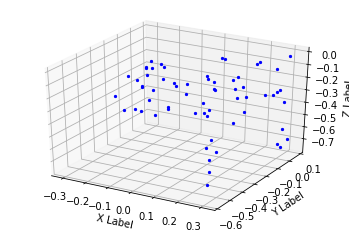

In [20]:
id = 112
show_pc(Anchor_train_orig[id,:,:])
